# <center>Rigid Body Replica Exchange - **GREX**
    
    TODO: a way to RESTART
    

In [1]:
# Imports
import os, sys, glob
import numpy as np

import ls_parsetxt
import ls_parsepdb

Text(0.5, 1.0, 'Resources')

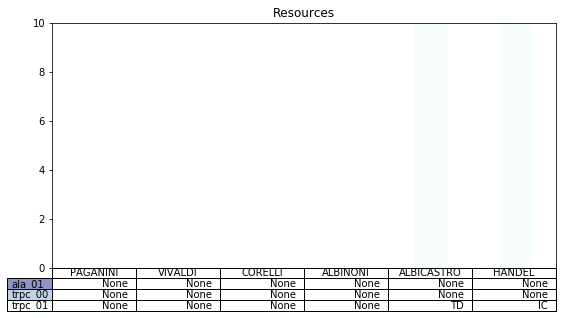

In [175]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


plt.rcParams['figure.figsize'] = [10, 5]

data = [[ 0, 0,  0, 0,  10, 10],
        [ 0, 0,  0, 0,  0, 0],
        [ 0, 0,  0, 0,  0, 0]
       ]

simType = [['None', 'None', 'None', 'None', 'TD','IC'],
           ['None', 'None', 'None', 'None', 'None','None'],
           ['None', 'None', 'None', 'None', 'None','None']
          ]

columns = ('PAGANINI', 'VIVALDI', 'CORELLI', 'ALBINONI', 'ALBICASTRO', 'HANDEL')
rows = ['ala_01', 'trpc_00', 'trpc_01']

values = np.arange(0, 12, 2)
value_increment = 2

# Get some pastel shades for the colors
colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))
n_rows = len(data)

index = np.arange(len(columns)) + 0.3
bar_width = 0.4

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
    y_offset = y_offset + data[row]
    cell_text.append(simType[row])
    
# Reverse colors and text labels to display the last value at the top.
colors = colors[::-1]
cell_text.reverse()

# Add a table at the bottom of the axes
the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
                      loc='bottom')

# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)


plt.xticks([])
plt.title('Resources')

<h1> General Functions

In [4]:
def removeEndComment(S):
    """
    Removes everything after # sign from a string
    """
    return S.split("#")[0]

# Generate Input

In [5]:
# Keyword categories
# IO / Run / Thermodynamics / Worlds / Software
class RobosampleInput:
    """
    Hold info in Robosample input file
    """
    
    def __init__(self, molDirs, outDir, writePdbFreq):
        """
        Sets IO parameters
        """
        # IO
        self.molDirs = molDirs
        self.nofMolecules = len(self.molDirs)
        self.outDir = outDir
        self.writePdbFreq = writePdbFreq
        
        # Worlds
        self.nofWorlds = 0
        self.flexFNs = [[None]]
        self.roots = [[None]]
        self.rootMobs = [[None]]
        self.sprs = [None] # samples per round
        
        # Sampling
        self.sampler = None
        self.tss = [None]
        self.mdsteps = [None]
        
        # Thermodynamics
        self.T = [None] # Temperature
        self.bT = [None] # Boost temperature
        self.ffscale = [None] # Force field scale (AMBER = 1)
        self.gbsa = [None] # GBSA scale
        self.fp = [None] # use Fixman potential
        self.ft= [None] # use Fixman torque
        
        # Replica exchange
        self.rexFN = None
        
        # Geometry
        self.geometry = False
        self.distances = [[0, 1]]
        self.dihedrals = [[0, 1, 2, 3]]
    #
    
    def defineWorlds(self, flexFNs, roots, rootMobs, samples_per_round):
        """
        param flexFNs: List of lists of flexibility files (worlds x mols)
        param roots: List of lists of roots
        param rootMobs: List of lists of root mobilities
        param samples_per_round: samples per round
        """
        self.sprs = samples_per_round
        self.nofWorlds = len(self.sprs)
        print(self.nofWorlds, flexFNs, len(flexFNs))
        assert(len(flexFNs) == self.nofMolecules)
        #for molFlexes in flexFNs:
        #    assert(len(molFlexes) == self.nofWorlds)
        assert(len(roots) == self.nofMolecules)
        assert(len(rootMobs) == self.nofMolecules)
        
        
        self.flexFNs = flexFNs
        self.roots = roots
        self.rootMobs = rootMobs
    #
    
    def defineSampling(self, sampler, tss, mdsteps):
        """
        Will use on sampler for all the worlds
        param sampler: sampler name (VV or HMC)
        param tss float: list of integration timesteps for samplers
        param mdsteps: # of integration steps
        """
        self.sampler = sampler
        self.tss = tss
        self.mdsteps = mdsteps
    #
    
    def defineThermodynamics(self, T, bT, ffscale, gbsa, fp, ft):
        self.T = T # Temperature
        self.bT = bT # Boost temperature
        self.ffscale = ffscale # Force field scale (AMBER = 1)
        self.gbsa = gbsa # GBSA scale
        self.fp = fp # use Fixman potential
        self.ft = ft # use Fixman torque
    #

    def defineREX(self, rexFile):
        self.rexFN = rexFile
    #

    def defineGeometry(self, distances, dihedrals):
        """
        distances: list of of 2 atom indexes lists
        dihedrals: list of of 4 atom indexes lists
        """
        self.geometry = True
        self.distances = distances
        self.dihedrals = dihedrals
    #
    
    def dump(self):
        print("IO (mol outDir pdbFreq): ", self.molDirs, self.outDir, self.writePdbFreq)
        print("Worlds flex, roots, samples: \n", self.flexFNs, self.roots, self.rootMobs, self.sprs)
        print("Sampling: ", self.sampler, self.tss, self.mdsteps)
        print("Thermodynamics: T, boostT, ffscale, GBSA, FP, FT", 
              self.T, self.bT, self.ffscale, self.gbsa, self.fp, self.ft)
    #
    
    def generateInput(self, seed, nofRounds):        
            # Params specific to this input
            runStr = "# Run\n"
            runStr += ("SEED " + str(seed) + \
                "\nROUNDS "  + str(nofRounds) + "\n" + \
                """REPRODUCIBLE FALSE
OPENMM TRUE
OPENMM_CalcOnlyNonbonded TRUE
""")
            runStr += "\n"

            # IO
            IOStr = "# IO\n"
            IOStr += "MOLECULES "
            for i in range(self.nofMolecules):
                IOStr += self.molDirs[i]
                
            IOStr += """
PRMTOP ligand.prmtop
INPCRD ligand.min.rst7
OUTPUT_DIR """ + self.outDir
                
            # Replica exchange
            if self.rexFN != None:
                rexStr = "\n\n# Replica exchange\n"
                rexStr += """RUN_TYPE REX
REX_SWAP_EVERY 1\n"""
                rexStr += ("REX_FILE " + self.rexFN)
            else:
                rexStr = "\n\nRUN_TYPE Normal"
                
            # Worlds flexibilities
            flexStr = "\n\n# Flexibility\n"
            flexStr += "RBFILE "
            for i in range(self.nofWorlds):
                for j in range(self.nofMolecules):
                    flexStr += "ligand.rb "
            flexStr += "\nFLEXFILE "
            for i in range(self.nofMolecules):
                for j in range(self.nofWorlds):
                    flexStr += (self.flexFNs[i][j] + " ")
            flexStr += "\nROOTS "
            for i in range(self.nofMolecules):
                for j in range(self.nofWorlds):
                    flexStr += (str(self.roots[i][j]) + " ")
            flexStr += "\nROOT_MOBILITY "
            for i in range(self.nofMolecules):
                for j in range(self.nofWorlds):
                    flexStr += (self.rootMobs[i][j] + " ")
            flexStr += "\n\n"        
            
            # Worlds
            worldsStr = "# Worlds\nRANDOM_WORLD_ORDER FALSE\n"
            worldsStr += "WORLDS "
            for i in range(self.nofWorlds): worldsStr += (" R" + str(i)) # Only 9 worlds
            worldsStr += "\nTHREADS"
            for i in range(self.nofWorlds): worldsStr += " 0"
            worldsStr += "\nNONBONDED_METHOD"
            for i in range(self.nofWorlds): worldsStr += " 0"
            worldsStr += "\nNONBONDED_CUTOFF"
            for i in range(self.nofWorlds): worldsStr += " 1.2"
            worldsStr += "\nVISUAL "
            for i in range(self.nofWorlds): worldsStr += " FALSE"
            worldsStr += "\nPRINT_FREQ "
            for i in range(self.nofWorlds): worldsStr += " 1"
            worldsStr += "\nROUNDS_TILL_REBLOCK "
            for i in range(self.nofWorlds): worldsStr += " 1"
            worldsStr += "\nSAMPLES_PER_ROUND "
            for i in range(self.nofWorlds): worldsStr += (" " + str(self.sprs[i]))
            worldsStr += "\nWRITEPDBS " + str(self.writePdbFreq)
            for i in range(self.nofWorlds - 1): worldsStr += " 0"
            worldsStr += "\n\n"

            # Geometry
            geomStr = "\nGEOMETRY "
            if self.geometry:
                for i in range(self.nofWorlds): geomStr += " TRUE"
            else:
                for i in range(self.nofWorlds): geomStr += " FALSE"
            geomStr += "\nDISTANCE "        
            for i in range(len(self.distances)):
                for j in range(len(self.distances[i])):
                    geomStr += (" " + str(self.distances[i][j]))
            geomStr += "\nDIHEDRAL "        
            for i in range(len(self.dihedrals)):
                for j in range(len(self.dihedrals[i])):
                    geomStr += (" " + str(self.dihedrals[i][j]))
                


            # Sampling
            samStr = "\n\n# Sampling\n"
            samStr += "SAMPLER "
            for i in range(self.nofWorlds): samStr += (" " + self.sampler)
            samStr += "\nTIMESTEPS "
            for i in range(self.nofWorlds): samStr += (" " + str(self.tss[i]))
            samStr += "\nMDSTEPS "
            for i in range(self.nofWorlds): samStr += (" " + str(self.mdsteps[i]))
            samStr += "\nBOOST_MDSTEPS "
            for i in range(self.nofWorlds): samStr += " 1"
            samStr += "\nNMA_OPTION "
            for i in range(self.nofWorlds): samStr += " 0"

            # Thermodynamics
            thermoStr = "\n\n# Thermodynamics\nTHERMOSTAT "
            for i in range(self.nofWorlds): thermoStr += " Andersen"            
            thermoStr += "\nTEMPERATURE_INI "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.T[i]))
            thermoStr += "\nTEMPERATURE_FIN "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.T[i]))
            thermoStr += "\nBOOST_TEMPERATURE "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.bT[i]))
            thermoStr += "\nFFSCALE "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.ffscale[i]))
            thermoStr += "\nGBSA "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.gbsa[i]))
            thermoStr += "\nFIXMAN_POTENTIAL "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.fp[i]))
            thermoStr += "\nFIXMAN_TORQUE "
            for i in range(self.nofWorlds): thermoStr += (" " + str(self.ft[i]))


                
            return runStr + IOStr + rexStr + flexStr + worldsStr + geomStr + samStr + thermoStr
        
        

    

In [6]:
# Replica exchange protocol
class REXProtocol:
    """
    Replica exchange protocol
    
    Given N worlds defined and K replicas, we need a 
    K x Nmax table of worlds per replica, where Nmax is 
    maximum nof worlds in a replica.
    
    Equivalent tables of timesteps, MD steps and samples per rounds
    are needed
    """    
    def __init__(self, Ti, Tf, nofWantedReplicas, distribution = "geometric"):
        """
        Generates a geometric distribution of Ts
        """
        self.nofReplicas = nofWantedReplicas
        self.Ts = []
        self.Ts.append(Ti)
        
        if(distribution == "geometric"):
            # Generate geometric distribution
            r = (Tf / Ti)**(1 / (nofWantedReplicas - 1)) # rate parameter
            for i in range(1, nofWantedReplicas):
                self.Ts.append(self.Ts[i-1] * r)
        else:
            self.Ts.append(Tf)
        
        self.Ts = np.array(self.Ts)
    #

    def getTs(self):
            return self.Ts
    #
    
    def loadWorldParams(self, worlds, tss, mdsteps, sprs):
        """
        Generates the tables of parameters for every world
        """
        assert(len(worlds) == self.nofReplicas)
        assert(len(tss) == len(mdsteps) == len(sprs) == len(worlds))
        
        self.rexWorlds = np.array(worlds, dtype = int)
        self.rexTss = np.array(tss, dtype = float)
        self.rexMdsteps = np.array(mdsteps, dtype = int)
        self.rexSprs = np.array(sprs, dtype = int)
    #    
    
    def generateTrexContent(self):
        """
        Write trex file
        param rexWorlds: list of worlds lists for each replica
        """
        assert(self.nofReplicas == len(rexWorlds))
        self.rexWorlds = rexWorlds
        rexStr = "NOF_REPLICAS " + str(self.nofReplicas) + "\n#Title\n"
        for i in range(self.nofReplicas):
            rexStr += (str(i) + " TEMPERATURE " + str((self.Ts[i]))) + "\n"
            rexStr += str(i) + " WORLD_INDEXES"
            for j in range(len(self.rexWorlds[i])):
                rexStr += " " + str(self.rexWorlds[i][j])
            rexStr += "\n" + str(i) + " TIMESTEPS"
            for j in range(len(self.rexWorlds[i])):
                rexStr += " " + str(self.rexTss[i][j])
            rexStr += "\n" + str(i) + " MDSTEPS"
            for j in range(len(self.rexWorlds[i])):
                rexStr += " " + str(self.rexMdsteps[i][j])
            rexStr += "\n" + str(i) + " SAMPLES_PER_ROUND"
            for j in range(len(self.rexWorlds[i])):
                rexStr += " " + str(self.rexSprs[i][j])                
            rexStr += "\n#\n"            
            
        return rexStr
    #

seeds:  [[1000 1001 1002 1003 1004 1005 1006 1007 1008 1009]
 [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009]
 [3000 3001 3002 3003 3004 3005 3006 3007 3008 3009]]
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1] [0 0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9]
[ 0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10]


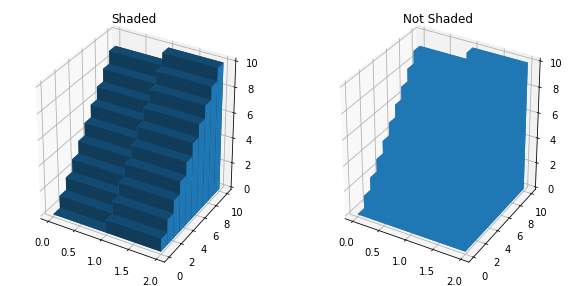

In [62]:
# DRY RUN OR NOT
dry = True

# IO and MOLECULE
molDirs = ["ala1"]
outDir = "temp"
writePdbFreq = 10

nofMols = len(molDirs)

# Experiment global parameters
nofRepeats = 10

# Regimens
IC = 0; TD = 1; RM = 2
regimens = np.array([IC, TD, RM], dtype = int)
regimenNames = ["ic", "td", "rm"]
regimenDOFs = [63, 7, 2]
usingFixman = ["FALSE", "TRUE", "TRUE"]
allFlexFNs = ["ligand.flex.cart", "ligand.flex.7td", "ligand.flex.2td"]

nofRegimens = regimens.size

# Seeds
seeds = np.zeros((nofRegimens, nofRepeats), dtype = int)
for regimen in range(nofRegimens):
    seeds[regimen] = (1000 * (regimen+1)) + np.arange(0, 10, 1)
print("seeds: ", seeds)

# Default world parameters
optimTss = np.array([0.0007, 0.003, 0.007])
optimMdsteps = np.array([300, 1166, 500])

#############
#### REX ####
#############
nofReplicas = 10
rexWorlds = [[0,1]]
rexWorlds += [[0, 2] for i in range(nofReplicas - 1)]

# Timesteps
rexTss = [None] * nofRegimens # timesteps
rexTss[IC] = [[optimTss[IC], optimTss[IC]]]
rexTss[TD] = [[optimTss[IC], optimTss[IC]]]
rexTss[RM] = [[optimTss[IC], optimTss[IC]]]

rexTss[IC] += [[optimTss[IC], optimTss[IC]] for i in range(nofReplicas - 1)]
rexTss[TD] += [[optimTss[IC], optimTss[TD]] for i in range(nofReplicas - 1)]
rexTss[RM] += [[optimTss[IC], optimTss[RM]] for i in range(nofReplicas - 1)]

# MD steps
rexMdsteps = [None] * nofRegimens # nof MD steps
rexMdsteps[IC] = [[0, optimMdsteps[IC]]]
rexMdsteps[TD] = [[0, optimMdsteps[IC]]]
rexMdsteps[RM] = [[0, optimMdsteps[IC]]]

rexMdsteps[IC] += [[0, optimMdsteps[IC]] for i in range(nofReplicas - 1)]
rexMdsteps[TD] += [[0, optimMdsteps[TD]]  for i in range(nofReplicas - 1)]
rexMdsteps[RM] += [[0, optimMdsteps[RM]]  for i in range(nofReplicas - 1)]

# Samples per round
rexSprs = [None] * nofRegimens 
rexSprs[IC] = [[1, 1] for i in range(nofReplicas)]
rexSprs[TD] = rexSprs[IC]
rexSprs[RM] = rexSprs[IC]

rexProtocol = REXProtocol(300, 1000, nofReplicas)
Ts = rexProtocol.getTs()

# Write trex files
trexFNs = []

for regimen in regimens:
    rexProtocol.loadWorldParams(rexWorlds, rexTss[regimen], rexMdsteps[regimen], rexSprs[regimen])    
    REXFContent = rexProtocol.generateTrexContent()
    its = rexProtocol.rexTss * rexProtocol.rexMdsteps

    trexFNs.append("trex." + regimenNames[regimen] + ".dT200.dat")
    if dry == False:
        with open(trexFNs[-1], 'w') as F:
            F.write(REXFContent)

# Plot
plt.rcParams['figure.figsize'] = [10, 5]            

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# fake data
_x = np.arange(2)
_y = np.arange(10)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel() 
print(x, y)

top = x + y
#top = rexMdsteps[:, TD]
print(top)
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')

ax2.bar3d(x, y, bottom, width, depth, top, shade=False)
ax2.set_title('Not Shaded')
            
plt.show()


<h2> Generate inputs </h2>

In [63]:
# DRY RUN OR NOT
dry = True

# Roots
roots = [[0 for i in range(nofRegimens)] for j in range(nofMols)]
rootMobs = [["Weld" for i in range(nofRegimens)] for j in range(nofMols)]

# Sampling
sampler ="HMC"
tss = [0.001 for i in range(nofRegimens)]
mdsteps = [10 for i in range(nofRegimens)]
sprs = [1 for i in range(nofRegimens)] # sampler per round

# Thermodynamics
T = [300.0 for i in range(nofRegimens)]
bT = [300.0 for i in range(nofRegimens)]
ffscale = ["AMBER" for i in range(nofRegimens)]
gbsa = [1.0 for i in range(nofRegimens)]
fp = usingFixman
ft = usingFixman

# Geometry
alaDistances = [[1, 18]]
alaDihedrals = [[4, 6, 8, 14], [6, 8, 14, 16]]

dT = int(200.0)

# REX things

# Worlds
nofRounds = 10000

# Write inp and batch files
for regimen in regimens:
    trexFN = trexFNs[regimen]
    flexFNs = [[allFlexFNs[0], allFlexFNs[0], allFlexFNs[regimen]]]

    roboInput = RobosampleInput(molDirs, outDir, writePdbFreq)
    roboInput.defineREX(trexFN)
    roboInput.defineWorlds(flexFNs, roots, rootMobs, sprs)
    roboInput.defineSampling(sampler, tss, mdsteps)
    roboInput.defineThermodynamics(T, bT, ffscale, gbsa, fp, ft)
    roboInput.defineGeometry(alaDistances, alaDihedrals)
    #roboInput.dump()

    batchStr = ""
    for seed in seeds[regimen]:        
        specStr = regimenNames[regimen] + ".dT" + str(dT) + "." + str(seed)
        inFN = "inp."
        outFN = "out."
        inFN += specStr
        outFN += specStr

        print(inFN, outFN)
        
        FContent = roboInput.generateInput(seed, nofRounds)
        if dry == False:
            with open(inFN, 'w') as F:
                F.write(FContent)
        
        batchStr += "nohup /home/laurentiu/git4/Robosample/build/release/robosample/src/GMOLMODEL_robo "
        batchStr += inFN
        batchStr += (" > " + outFN + " 2>&1 &\n")
        
    batchFN = "batch." + regimenNames[regimen] + ".bash"
    print(batchFN)

    if dry == False:    
        with open(batchFN, "w") as batchF:
            batchF.write(batchStr)


3 [['ligand.flex.cart', 'ligand.flex.cart', 'ligand.flex.cart']] 1
inp.ic.dT200.1000 out.ic.dT200.1000
inp.ic.dT200.1001 out.ic.dT200.1001
inp.ic.dT200.1002 out.ic.dT200.1002
inp.ic.dT200.1003 out.ic.dT200.1003
inp.ic.dT200.1004 out.ic.dT200.1004
inp.ic.dT200.1005 out.ic.dT200.1005
inp.ic.dT200.1006 out.ic.dT200.1006
inp.ic.dT200.1007 out.ic.dT200.1007
inp.ic.dT200.1008 out.ic.dT200.1008
inp.ic.dT200.1009 out.ic.dT200.1009
batch.ic.bash
3 [['ligand.flex.cart', 'ligand.flex.cart', 'ligand.flex.7td']] 1
inp.td.dT200.2000 out.td.dT200.2000
inp.td.dT200.2001 out.td.dT200.2001
inp.td.dT200.2002 out.td.dT200.2002
inp.td.dT200.2003 out.td.dT200.2003
inp.td.dT200.2004 out.td.dT200.2004
inp.td.dT200.2005 out.td.dT200.2005
inp.td.dT200.2006 out.td.dT200.2006
inp.td.dT200.2007 out.td.dT200.2007
inp.td.dT200.2008 out.td.dT200.2008
inp.td.dT200.2009 out.td.dT200.2009
batch.td.bash
3 [['ligand.flex.cart', 'ligand.flex.cart', 'ligand.flex.2td']] 1
inp.rm.dT200.3000 out.rm.dT200.3000
inp.rm.dT200.3001

# Analyze Output

In [12]:
!ls

00.vmd		   inp.rm.dT200.3007	   out.td.dT200.2003
01study.vmd	   inp.rm.dT200.3008	   out.td.dT200.2004
02.vmd		   inp.rm.dT200.3009	   out.td.dT200.2005
03.vmd		   inp.td.dT200.2000	   out.td.dT200.2006
ala1		   inp.td.dT200.2001	   out.td.dT200.2007
batch.ic.bash	   inp.td.dT200.2002	   out.td.dT200.2008
batch.rm.bash	   inp.td.dT200.2003	   out.td.dT200.2009
batch.td.bash	   inp.td.dT200.2004	   rexz.ipynb
inp.ic.dT200.1000  inp.td.dT200.2005	   robots
inp.ic.dT200.1001  inp.td.dT200.2006	   simulate.py
inp.ic.dT200.1002  inp.td.dT200.2007	   temp
inp.ic.dT200.1003  inp.td.dT200.2008	   temp.png
inp.ic.dT200.1004  inp.td.dT200.2009	   thermoState.npy
inp.ic.dT200.1005  inp.test		   trex.ic.dT200.dat
inp.ic.dT200.1006  inp.try.9003		   trex.rm.dT200.dat
inp.ic.dT200.1007  inp.vv.9000		   trex.td.dT200.dat
inp.ic.dT200.1008  inp.vv.cacb.9003	   trpc
inp.ic.dT200.1009  inp.vv.double.9001	   trpch
inp.rm.dT200.3000  inp.vv.siderm.9002	   vmdcommand.bash
inp.rm.dT200.3001  ligand.min.rst

In [64]:

#print(FNList)

# Fixed number of worlds per replica 
nofWorldsPerReplica = np.max([len(w) for w in rexWorlds])

print("nof worlds per replica", nofWorldsPerReplica)

nof worlds per replica 2


<h2> Check trex file </h2>

In [14]:
# Check trex files

def checkTrex(trexFN):
    
    Ts = np.zeros((1))
    worlds = np.zeros((1, nofWorldsPerReplica))
    tss = np.zeros((1, nofWorldsPerReplica))
    mdsteps = np.zeros((1, nofWorldsPerReplica))
    spr = np.zeros((1, nofWorldsPerReplica))
    
    with open(trexFN, "r") as F:
        all_lines = F.readlines()
        linei = -1
        for line in all_lines:
            linei += 1
            words = line.split()
            if words[0][0] != "#":
                if words[0] == "NOF_REPLICAS":
                    nofReplicas = int(words[1])
                    Ts.resize((nofReplicas))
                    worlds.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                    tss.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                    mdsteps.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                    spr.resize((nofReplicas, nofWorldsPerReplica)) # HARDCODED !!!!
                else:
                    if not nofReplicas:
                        "NOF_REPLICAS not set first in grex file."
                        break
                    else:
                        K = int(words[0])
                        if words[1] == "TEMPERATURE":
                            Ts[K] = float(words[2])
                        
                        elif words[1] == "WORLD_INDEXES":
                            for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                                worlds[K, wi] = words[2+wi]

                        elif words[1] == "TIMESTEPS":
                            for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                                tss[K, wi] = words[2+wi]
                                
                        elif words[1] == "MDSTEPS":
                            for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                                mdsteps[K, wi] = words[2+wi]
                                
                        elif words[1] == "SAMPLES_PER_ROUND":
                            for wi in range(nofWorldsPerReplica): # HARDCODED !!!
                                spr[K, wi] = words[2+wi]                        

    print("nofReplicas", nofReplicas)                                    
    print("Ts", Ts)
    print("worlds", worlds)
    print("tss", tss)
    print("mdsteps", mdsteps)
    print("spr", spr)

trexFN = "trex.td.dT200.dat"    
checkTrex(trexFN)    



nofReplicas 10
Ts [ 300.          342.94059189  392.02749856  448.14047466  512.28519877
  585.61129762  669.43295008  765.25244045  874.78708292 1000.        ]
worlds [[0. 1.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]
 [0. 2.]]
tss [[0.0007 0.0007]
 [0.0007 0.003 ]
 [0.0007 0.003 ]
 [0.0007 0.003 ]
 [0.0007 0.003 ]
 [0.0007 0.003 ]
 [0.0007 0.003 ]
 [0.0007 0.003 ]
 [0.0007 0.003 ]
 [0.0007 0.003 ]]
mdsteps [[   0.  300.]
 [   0. 1166.]
 [   0. 1166.]
 [   0. 1166.]
 [   0. 1166.]
 [   0. 1166.]
 [   0. 1166.]
 [   0. 1166.]
 [   0. 1166.]
 [   0. 1166.]]
spr [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


<h2> Function: Get Data from an output file </h2>

In [15]:
# Get output
def getOutputData(outFN, outD):
    """
    Read data from an Robosample output file outFN
    and put it in a numpy array outD
    """
    batchi = -1
    with open(outFN, "r") as F:
        all_lines = F.readlines()
        linei = -1
        for line in all_lines:
            linei += 1
            line.replace(" ", "").replace(",", "",100)
            words = line.split()
            if  (words[0] == "REX") and (words[1] == "batch"):
                batchi += 1
                replicai = -1
            elif (words[0] == "REX") and (words[1] == "replica"):
                replicai += 1
                worldi = -1            
            elif (words[0] == "Temperature") and (words[1] == "set") and (words[2] == "to"):
                for j in range(nofWorldsPerReplica):
                    outD[batchi][replicai][j][0] = float(words[3])                
            elif (words[0] == "World") and (words[2] == "NU"):
                worldi += 1
            elif(words[0] == "pe_o"):
                pe_o = float(words[1].replace(",", ""))
                pe_n = float(words[3].replace(",", ""))
                outD[batchi][replicai][worldi][1] = pe_o
                outD[batchi][replicai][worldi][2] = pe_n

            elif(words[0] == "ke_prop"):
                ke_prop = float(words[1].replace(",", ""))
                ke_n = float(words[3].replace(",", ""))
                outD[batchi][replicai][worldi][3] = ke_prop
                outD[batchi][replicai][worldi][4] = ke_n

            elif(words[0] == "fix_o"):
                fix_o = float(words[1].replace(",", ""))
                fix_n = float(words[3].replace(",", ""))
                outD[batchi][replicai][worldi][5] = fix_o
                outD[batchi][replicai][worldi][6] = fix_n

            elif (len(words) > 2) and (words[2] == "(metropolis-hastings)"):
                if words[1] == "accepted":
                    acc = 1.0
                else:
                    acc = 0.0
                outD[batchi][replicai][worldi][7] = acc
            
            #if linei > 500:
            #    print(outD)
            #    break
            
        return outD
#



<h2>Get Output Data</h2>

Get output data , thermodynamic state data and their correspondence (mix)

In [128]:
# Indeces
nofIndexes = 8
Ix_T = 0
Ix_pe_o = 1
Ix_pe_n = 2
Ix_ke_prop = 3
Ix_ke_n = 4
Ix_fix_o = 5
Ix_fix_n = 6
Ix_acc = 7

# Results file names
outDataFN = "out.npy"
thermoDataFN = "thermoState.npy"
mixDataFN = "mix.npy"
logDataFN = "logData.npy"
xrateDataFN = "xrate.npy"

# Output data
outD = np.zeros((nofRegimens, nofRepeats, nofRounds, nofReplicas, nofWorldsPerReplica, nofIndexes), dtype = float) * np.nan
thermoStateD = np.zeros(outD.shape, dtype = float) * np.nan
mix = np.zeros((nofRegimens, nofRepeats, nofRounds, nofReplicas)) * np.nan
xrateD = np.zeros((nofRegimens, nofRepeats, nofRounds, nofReplicas)) * np.nan

<h3> Get and save data </h3>
This only needs to be run once

In [129]:
# Get output data , thermodynamic state data and their correspondence (mix)
for regimen in range(nofRegimens):
    for repeat in range(nofRepeats): 
        outFN = "out." + regimenNames[regimen] + ".dT200." + str(seeds[regimen, repeat])
        print(outFN)
        outD[regimen, repeat] = getOutputData(outFN, outD[regimen, repeat])

        # Thermodynamic state data and correspondence
        roundi = -1
        for D in outD[regimen, repeat]: # D = [replica world data]
            roundi += 1
            replicai = -1
            for replica in D: # replica = [world, data]
                replicai += 1
                replicaT = replica[0, 0]
                for tix in range(Ts.size):
                    if (replicaT - Ts[tix]) < 0.000001:
                        thermoStateD[regimen, repeat, roundi, tix] = replica
                        mix[regimen, repeat, roundi, tix] = replicai
                        break
                        
np.save(outDataFN, outD)
np.save(thermoDataFN, thermoStateD)
np.save(mixDataFN, mix)        

out.ic.dT200.1000
out.ic.dT200.1001
out.ic.dT200.1002
out.ic.dT200.1003
out.ic.dT200.1004
out.ic.dT200.1005
out.ic.dT200.1006
out.ic.dT200.1007
out.ic.dT200.1008
out.ic.dT200.1009
out.td.dT200.2000
out.td.dT200.2001
out.td.dT200.2002
out.td.dT200.2003
out.td.dT200.2004
out.td.dT200.2005
out.td.dT200.2006
out.td.dT200.2007
out.td.dT200.2008
out.td.dT200.2009
out.rm.dT200.3000
out.rm.dT200.3001
out.rm.dT200.3002
out.rm.dT200.3003
out.rm.dT200.3004
out.rm.dT200.3005
out.rm.dT200.3006
out.rm.dT200.3007
out.rm.dT200.3008
out.rm.dT200.3009


In [142]:
import re

# Get output
def getXrateData(outFN, xrateD):
    """
    Read data from an Robosample output file outFN
    and put it in a numpy array outD
    """
    flag = 0
    count = -1
    roundi = -1
    with open(outFN, "r") as F:
        all_lines = F.readlines()
        linei = -1
        for line in all_lines:
            linei += 1
            line.replace(" ", "").replace(",", "",100)
                        
            words = line.split()
            
            if(flag == 1):
                count += 1
                if count < nofReplicas - 1:
                    #print(roundi, count, words)
                    xrateD[roundi, count] = float(words[count + 1])
                else:
                    count = -1
                    flag = 0
            
            if((words[0] == "Number") and (words[4] == "matrix:")):
                flag = 1
                roundi += 1
                if(roundi >= nofRounds):
                    break
                    
    return xrateD
                

In [143]:

for regimen in range(nofRegimens):
    for repeat in range(nofRepeats): 
        outFN = "out." + regimenNames[regimen] + ".dT200." + str(seeds[regimen, repeat])
        print(outFN)
        xrateD[regimen, repeat] = getXrateData(outFN, xrateD[regimen, repeat])

np.save(xrateDataFN, xrateD)


out.ic.dT200.1000
out.ic.dT200.1001
out.ic.dT200.1002
out.ic.dT200.1003
out.ic.dT200.1004
out.ic.dT200.1005
out.ic.dT200.1006
out.ic.dT200.1007
out.ic.dT200.1008
out.ic.dT200.1009
out.td.dT200.2000
out.td.dT200.2001
out.td.dT200.2002
out.td.dT200.2003
out.td.dT200.2004
out.td.dT200.2005
out.td.dT200.2006
out.td.dT200.2007
out.td.dT200.2008
out.td.dT200.2009
out.rm.dT200.3000
out.rm.dT200.3001
out.rm.dT200.3002
out.rm.dT200.3003
out.rm.dT200.3004
out.rm.dT200.3005
out.rm.dT200.3006
out.rm.dT200.3007
out.rm.dT200.3008
out.rm.dT200.3009


<h3> Load data from npys </h3>

In [145]:
outD = np.load(outDataFN)
thermoStateD = np.load(thermoDataFN)
mix = np.load(mixDataFN)
xrateD = np.load(xrateDataFN)

for regimen in range(nofRegimens):
    for repeat in range(nofRepeats):
        for roundi in range(1, nofRounds):
            for replicai in range(nofReplicas):
                xrateD[regimen, repeat, roundi, replicai] /= roundi


#print(outD[0, 0])
print(xrateD[0, 0])     

[[1.         1.         0.         ... 0.         0.                nan]
 [2.         1.         0.         ... 1.         0.                nan]
 [1.         1.         0.         ... 1.         0.                nan]
 ...
 [0.59917975 0.61378414 0.61078323 ... 0.61188357 0.62348705        nan]
 [0.59921984 0.61382276 0.61082216 ... 0.61192238 0.62342468        nan]
 [0.59915992 0.61386139 0.61086109 ... 0.61186119 0.62336234        nan]]


<h3> Random timeseries </h3>

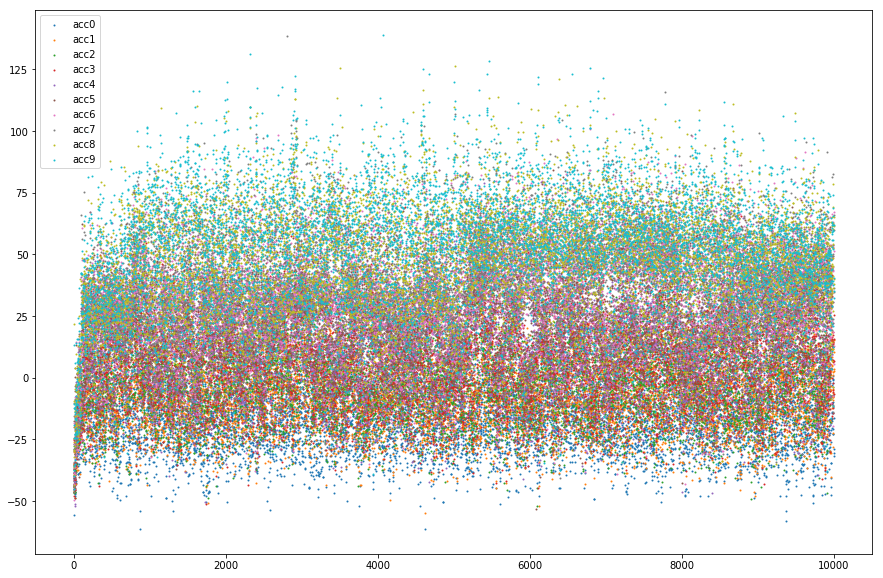

In [134]:
# Plot random timeseries here
regimen = TD
repeat = 0
#print(thermoStateD[regimen, repeat])

# For every replica extract 1D series for some obs. (PE, KE, ...)
colData = [None] * nofReplicas
Ix_colData = Ix_pe_o # column
worldIx = 0 # 

#Ix_colData = Ix_acc # column
#worldIx = 1 # 

replicaRange = range(1, 2)
for k in range(nofReplicas):
#for k in replicaRange:

    colData[k] = thermoStateD[regimen, repeat,:, k, worldIx, Ix_colData]
    colData[k] = colData[k][np.logical_not(np.isnan(colData[k]))]
    #print(colData[k])
        
plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(1, 1)
for k in range(nofReplicas):
#for k in replicaRange:
    axs.scatter(range(colData[k].size), colData[k], s = 1, label = "acc" + str(k))
    #axs.plot(range(colData[k].size), colData[k], label = "acc" + str(k))

plt.legend()
plt.show()    

In [135]:
def outDataHistogram(data, worldIx, dataIx, regimen = [0], nbins = 20, histRange = None):
    """
    Extracts data and returns histograms
    data: data[regimen, repeat, round, replica, worldIx, dataIx]
        the only variable is the round
    worldIx: world index in the array (differs from the index in trex file)
    dataIx: T pe_o pe_n ke_prop ke_n fix_o fix_n acc
    """
    data_min = None
    data_max = None
    histStep = None
        
    if histRange == None:
        data_min = np.nanmin(data[regimen, :, :, :, worldIx, dataIx])
        data_max = np.nanmax(data[regimen, :, :, :, worldIx, dataIx])
        histRange = (data_min, data_max)
    else:
        data_min = histRange[0]
        data_max = histRange[1]
    
    histStep = (data_max - data_min) / nbins
        
    XAxis = np.arange(data_min, data_max, histStep)

    smallDataHists = np.zeros((nofRepeats, nofReplicas, nbins), dtype=float) * np.nan
    smallDataHistsAvg = np.zeros((nofReplicas, nbins))
    smallDataHistsStd = np.zeros((nofReplicas, nbins))

    smallData = [None] * nofReplicas

    for repeat in range(nofRepeats):
        for k in range(nofReplicas):
            #print(data[regimen, repeat, :, k, worldIx, dataIx])
            smallData[k] = data[regimen, repeat, :, k, worldIx, dataIx]
            smallData[k] = smallData[k][np.logical_not(np.isnan(smallData[k]))]
            smallDataHists[repeat, k] = np.histogram(smallData[k], bins = nbins, range = histRange)[0]
        
    for k in range(nofReplicas):
        smallDataHistsAvg[k] = np.mean(smallDataHists[:, k], axis = 0)
        smallDataHistsStd[k] = np.std(smallDataHists[:, k], axis = 0)        
    
    return (XAxis, smallDataHistsAvg, smallDataHistsStd)
#

<h2> Kinetic Energy

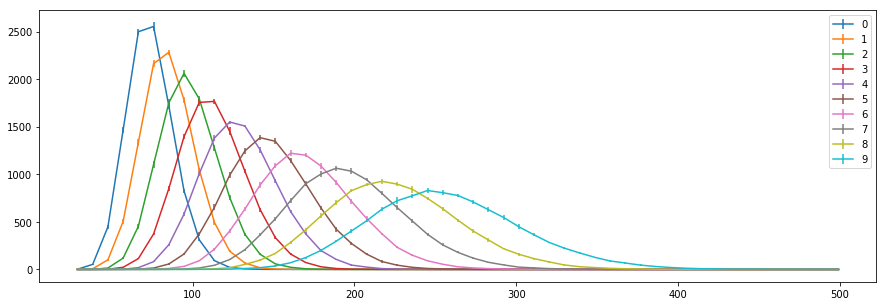

In [136]:
regimen = TD
repeat = 0

# Kinetic energy
worldIx = 0 # Full proposed KE is only in world 0
nbins = 51
(XAxis, KHistsAvg, KHistsStd) = outDataHistogram(thermoStateD,
    worldIx, Ix_ke_prop, regimen = [TD],
    nbins = nbins)

#print(KHistsAvg)    
    
plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(1, 1)
for k in range(0, nofReplicas):
    axs.errorbar(XAxis, KHistsAvg[k], yerr = KHistsStd[k], label = str(k))
    #axs.set_xlim(0, 500)
plt.legend()
plt.show()


<h1>  Potential Energy

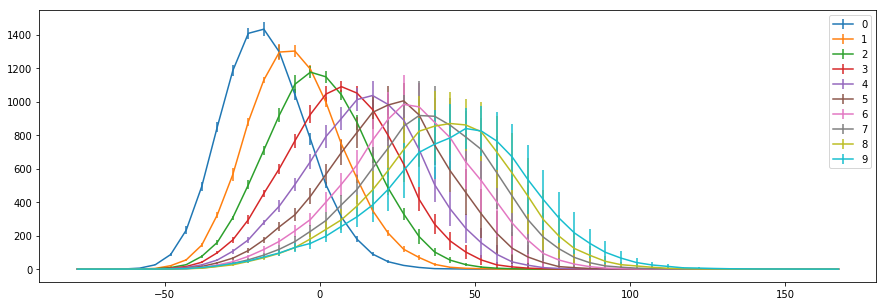

In [137]:
regimen = TD
repeat = 0

# Potential energy
worldIx = 0 # Full PE is only in world 0
nbins = 50
#[regimen, repeat, round, replica, worldIx, dataIx]
(XAxis, UHistsAvg, UHistsStd) = outDataHistogram(thermoStateD[:,:,:,:,:,:],
    worldIx, Ix_pe_o, regimen = [regimen], 
    nbins = nbins#, histRange = (600, 5000)
    )

#print(XAxis)
#print(UHistsAvg)

# Plot
plt.rcParams['figure.figsize'] = [15, 5]
fig, axs = plt.subplots(1, 1)
for k in range(0, nofReplicas):
    #axs.plot(UHists[k][1][:-1], UHists[k][0], label = str(k))
    axs.errorbar(XAxis, UHistsAvg[k], yerr = UHistsStd[k], label = str(k))
    #axs.set_xlim(-1800, -1400)
    #axs.set_ylim(0, 100)
    
plt.legend()
plt.show()

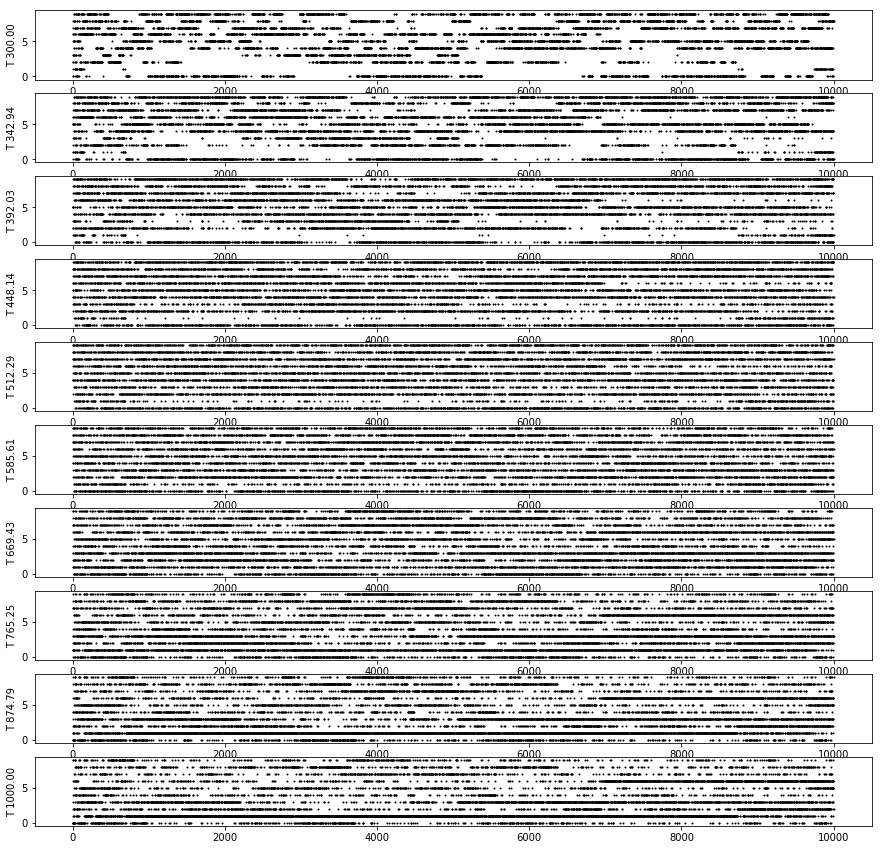

In [149]:
stride = 1
plt.rcParams['figure.figsize'] = [15, 15]
fig, axs = plt.subplots(nofReplicas, 1)
for k in range(nofReplicas):
    #axs[k].plot(range(len(mix[regimen, repeat,:,k][::stride])), mix[regimen, repeat,:,k][::stride], color = 'black')
    axs[k].scatter(range(len(mix[regimen, repeat,:,k][::stride])), 
                   mix[regimen, repeat,:,k][::stride],
                   s=1, color = 'black')
    axs[k].set_ylabel("T " + str("%.2f" % Ts[k]))
    
plt.show()

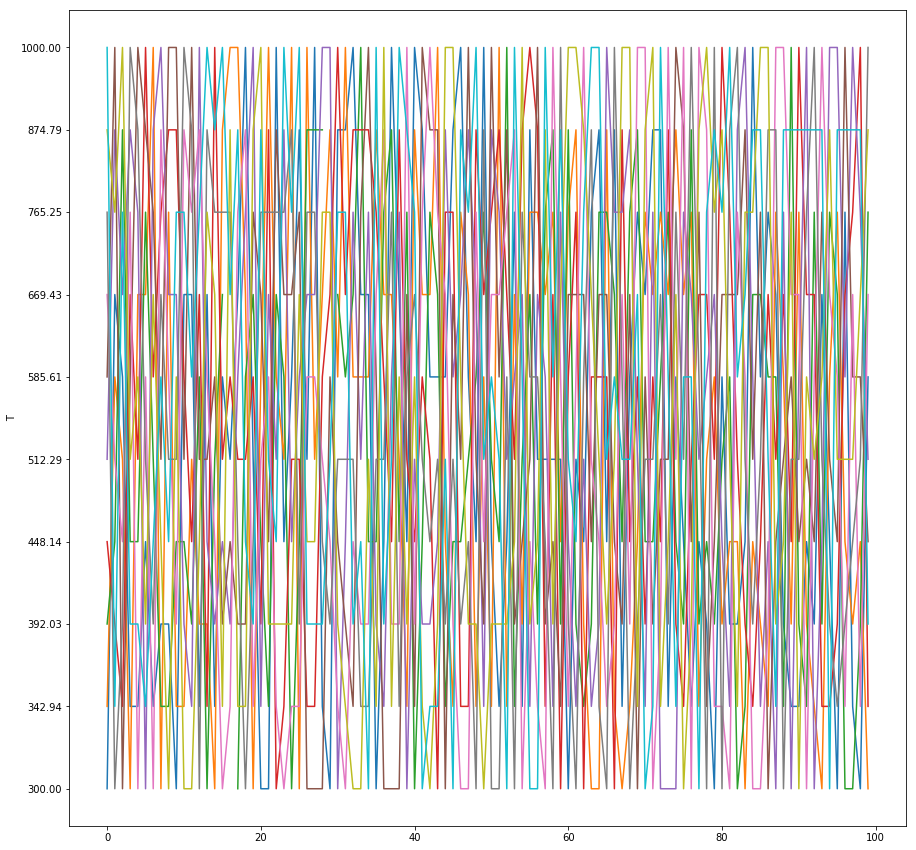

In [147]:
fig, axs = plt.subplots(1, 1)
stride = 100
for k in range(nofReplicas):
    #axs.scatter(range(len(mix[regimen, repeat,:,k][0:-1:stride])), mix[regimen, repeat,:,k][0:-1:stride])
    axs.plot(range(len(mix[regimen, repeat,:,k][0:-1:stride])), mix[regimen, repeat,:,k][0:-1:stride])
axs.set_ylabel("T")
axs.set_yticks(range(Ts.size))
axs.set_yticklabels([("%.2f" % Ts[k]) for k in range(nofReplicas)])
    
plt.show()

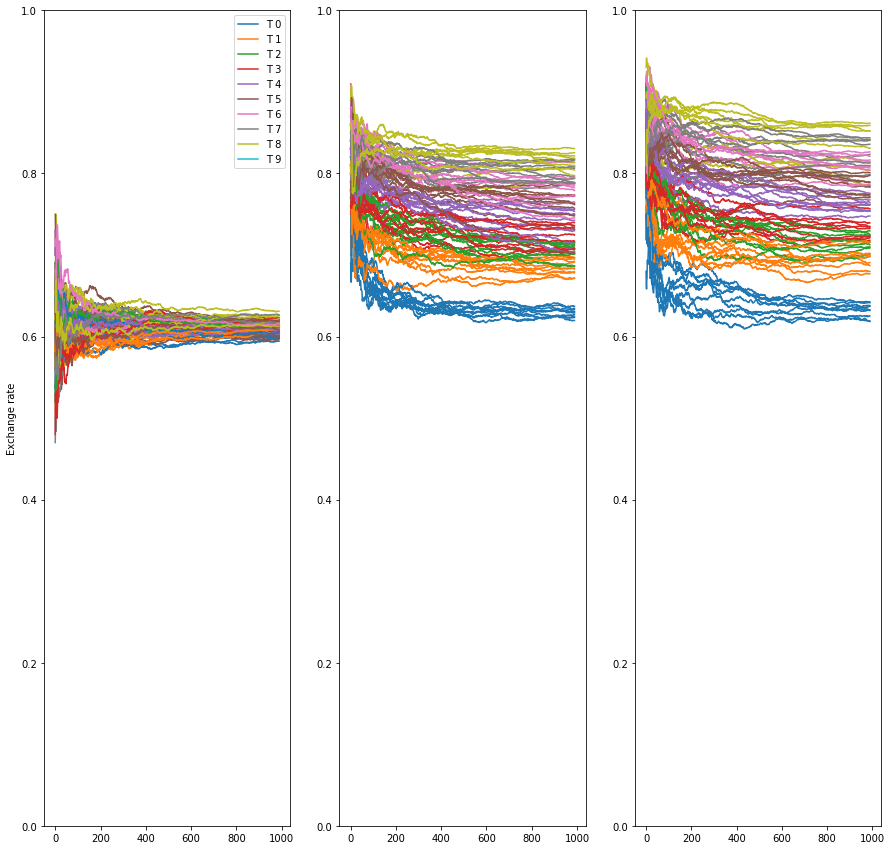

In [148]:
# Exchange rate
xrate = np.zeros(mix.shape, dtype = float)

# Create v with arange ... is better
v = np.ones(xrate.shape, dtype = float)

regimen = TD
repeat = 0

# Compute exchange rate
for regi in range(nofRegimens):
    for ri in range(nofRepeats):
        for i in range(1, nofRounds):
            for j in range(nofReplicas):
                v[regi, ri, i, j] += v[regi, ri, i-1, j]
                # Check if exchange happend
                if mix[regi, ri, i-1, j] != mix[regi, ri, i, j]:
                    xrate[regi, ri, i, j] = xrate[regi, ri, i-1, j] + 1.0
                else:
                    xrate[regi, ri, i, j] = xrate[regi, ri, i-1, j]

xrate /= v

fig, axs = plt.subplots(1, 3)
for regi in range(nofRegimens):
    for ri in range(nofRepeats):
        for k in range(nofReplicas):
            Y = xrateD[regi, ri, :,k][::10][10:]
            X = range(Y.size)
            axs[regi].set_ylim(0, 1)
            if((regi == 0) and (ri == 0)):
                axs[regi].plot(X, Y, label = "T " + str(k))
            else:
                axs[regi].plot(X, Y)
            if(regi == 0):
                axs[regi].set_ylabel("Exchange rate")
    
axs[0].legend()    
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  


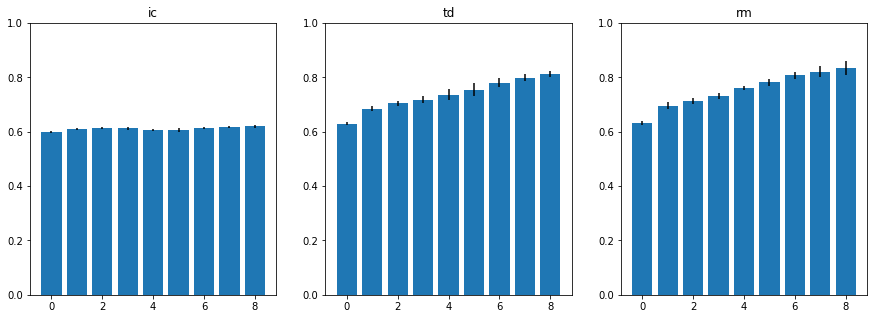

In [169]:
avgXrateD = np.zeros((nofRegimens, nofReplicas), dtype = float) * np.nan
stdXrateD = np.zeros((nofRegimens, nofReplicas), dtype = float) * np.nan

for regimen in range(nofRegimens):
    for replicai in range(nofReplicas):
        avgXrateD[regimen, replicai] = np.nanmean(xrateD[regimen, :, -1, replicai])
        stdXrateD[regimen, replicai] = np.nanstd(xrateD[regimen, :, -1, replicai])

plt.rcParams['figure.figsize'] = [15, 5]

fig, axs = plt.subplots(1, 3)
for regimen in range(nofRegimens):
    X = range(avgXrateD[regimen].size)
    Y = avgXrateD[regimen]
    Yerr = stdXrateD[regimen]
    axs[regimen].bar(X, Y, yerr = Yerr, label = str(regimen))
    axs[regimen].set_ylim(0, 1)
    axs[regimen].set_title(regimenNames[regimen])
    
plt.show()

